In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
from dynamic_portfolio.utils import load_csv
from dynamic_portfolio.utils import features_creation
from dynamic_portfolio.preprocess import scaler

# Loading data and creating clean dataframe

In [38]:
df = features_creation('META')

/Users/ericvincent/code/dynamic_portfolio/dynamic_portfolio/utils.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['return'][0]=0


In [39]:
pd.set_option('display.max_columns', None)

In [40]:
df

,date,volume,dividend_amount,split_coefficient,reportedEPS,surprisePercentage,10Y_yield,2Y_yield,10_2_spread,oil_price,orders,fed_funds,unemployment_rate,inf_exp,non_farm_payroll,CPI,retail_sales,gdp_per_capita,gold_price,usd_price,return,high/low,volatility_5days,volatility_10days,volatility_20days,momentum_5days,momentum_10days,momentum_20days,distance_5days,distance_10days,distance_20days,volume_5days,volume_10days,volume_20days,volume_momentum_5days,volume_momentum_10days,volume_momentum_20days,price/eps,momentum_5days/eps,momentum_10days/eps,momentum_20days/eps,gold_return,10Y_return,2Y_return,spread_return,oil_return,usd_return,unemployement_return,cpi_return,non_farm_payroll_return,gdp_return
0,2013-06-03,35733800.0,0.0,1.0,0.12,0.0,0.0213,0.0030,0.0183,93.41,260225.0,0.0010,0.075,0.03,137208.0,233.504,369316.0,51982.0,1411.1000,82.680000,-0.020536,0.025728,0.034365,0.024004,0.019205,-0.005284,-0.006783,-0.008480,-0.002945,-0.001445,0.000251,1.501481,1.254859,1.131900,53940720.0,45080810.0,40663510.00,198.733333,-0.044029,-0.056527,-0.070663,0.017816,-0.013889,0.000000,-0.016129,0.016099,-0.008395,0.0,0.004184,0.00958,0.005416
1,2013-06-04,34760800.0,0.0,1.0,0.12,0.0,0.0214,0.0032,0.0182,93.36,260225.0,0.0011,0.075,0.03,137208.0,233.504,369316.0,51982.0,1399.0400,82.769997,-0.013754,0.026158,0.032927,0.023996,0.019125,-0.003425,-0.009296,-0.008369,-0.017111,-0.011239,-0.012167,1.380819,1.279123,1.106092,49341900.0,45707920.0,39524880.00,196.000000,-0.028541,-0.077467,-0.069741,-0.008547,0.004695,0.066667,-0.005464,-0.000535,0.001088,0.0,0.004184,0.00958,0.005416
2,2013-06-05,53819700.0,0.0,1.0,0.12,0.0,0.0210,0.0030,0.0180,93.66,260225.0,0.0009,0.075,0.03,137208.0,233.504,369316.0,51982.0,1402.8000,82.570000,-0.026403,0.040149,0.033204,0.023831,0.018714,-0.004428,-0.008801,-0.007748,-0.009326,-0.004953,-0.006006,1.331331,1.292942,1.123851,46278120.0,44943710.0,39065950.00,190.825000,-0.036897,-0.073341,-0.064566,0.002688,-0.018692,-0.062500,-0.010989,0.003213,-0.002416,0.0,0.004184,0.00958,0.005416
3,2013-06-06,31260700.0,0.0,1.0,0.12,0.0,0.0208,0.0030,0.0178,94.71,260225.0,0.0010,0.075,0.03,137208.0,233.504,369316.0,51982.0,1413.1500,81.519997,0.003101,0.018527,0.032036,0.024371,0.018799,-0.003235,-0.011057,-0.007833,-0.023168,-0.015346,-0.018570,0.821158,0.886284,0.737536,44194500.0,47699550.0,39693980.00,191.416667,-0.026960,-0.092141,-0.065275,0.007378,-0.009524,0.000000,-0.011111,0.011211,-0.012717,0.0,0.004184,0.00958,0.005416
4,2013-06-07,38699200.0,0.0,1.0,0.12,0.0,0.0217,0.0032,0.0185,96.11,260225.0,0.0009,0.075,0.03,137208.0,233.504,369316.0,51982.0,1383.8900,81.690002,0.013975,0.023622,0.011389,0.024547,0.018585,-0.013164,-0.008794,-0.008108,0.016265,0.011895,0.011208,1.225180,1.480906,1.264344,38300000.0,46294170.0,39524270.00,194.091667,-0.109700,-0.073287,-0.067563,-0.020706,0.043269,0.066667,0.039326,0.014782,0.002085,0.0,0.004184,0.00958,0.005416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2355,2022-11-16,33287773.0,0.0,1.0,1.64,0.0,0.0367,0.0435,-0.0068,85.62,273451.0,0.0383,0.037,0.05,154369.0,298.012,597492.0,60082.0,1773.7700,106.279999,-0.032883,0.030312,0.040132,0.042763,0.070017,0.039557,0.023919,-0.004142,-0.014517,0.001120,0.029181,1.359774,1.430422,1.474764,68900407.6,72480208.1,74727034.80,69.042683,0.024120,0.014585,-0.002525,-0.002519,-0.034211,-0.004577,0.192982,-0.014389,-0.001128,0.0,0.000000,0.00000,-0.001197
2356,2022-11-17,35093822.0,0.0,1.0,1.64,0.0,0.0377,0.0443,-0.0066,81.69,273451.0,0.0383,0.037,0.05,154369.0,298.012,597492.0,60082.0,1760.8700,106.690002,-0.015720,0.023042,0.049322,0.046404,0.070306,0.033497,0.018441,-0.005323,-0.066381,-0.051324,-0.027560,1.956884,1.946361,2.256660,65140298.2,64790023.7,75119174.50,67.957317,0.020425,0.011244,-0.003246,-0.007273,0.027248,0.018391,-0.029412,-0.045900,0.003858,0.0,0.00000

In [41]:
final_df = scaler(df)

In [42]:
final_df

,date,volume,dividend_amount,split_coefficient,reportedEPS,surprisePercentage,10Y_yield,2Y_yield,10_2_spread,oil_price,orders,fed_funds,unemployment_rate,inf_exp,non_farm_payroll,CPI,retail_sales,gdp_per_capita,gold_price,usd_price,return,high/low,volatility_5days,volatility_10days,volatility_20days,momentum_5days,momentum_10days,momentum_20days,distance_5days,distance_10days,distance_20days,volume_5days,volume_10days,volume_20days,volume_momentum_5days,volume_momentum_10days,volume_momentum_20days,price/eps,momentum_5days/eps,momentum_10days/eps,momentum_20days/eps,gold_return,10Y_return,2Y_return,spread_return,oil_return,usd_return,unemployement_return,cpi_return,non_farm_payroll_return,gdp_return
0,2013-06-03,0.294681,0.0,0.0,-0.701087,0.0,-0.024824,-0.897752,1.199225,1.280259,0.928033,-0.770122,1.285714,0.333333,-1.005589,-0.738566,-0.635053,-1.025000,-0.067567,-1.687964,-0.020536,0.004182,1.016669,0.273493,-0.155222,-0.600221,-1.096056,-1.915444,-0.134910,-0.063517,0.008797,1.349448,0.379317,-0.026384,1.278479,0.891036,0.709577,1.251624,-1.960890,-3.313929,-5.298757,1.904605,-0.473445,-0.048207,-0.101791,0.229483,-1.965779,0.0,0.323016,0.527370,-1.000941
1,2013-06-04,0.252715,0.0,0.0,-0.701087,0.0,-0.010387,-0.877481,1.185417,1.278047,0.928033,-0.758694,1.285714,0.333333,-1.005589,-0.738566,-0.635053,-1.025000,-0.114282,-1.674650,-0.013754,0.032270,0.918700,0.272894,-0.162097,-0.421013,-1.453882,-1.892816,-0.786789,-0.489726,-0.521533,0.963205,0.444926,-0.089697,1.043409,0.925616,0.641273,1.197938,-1.316986,-4.479569,-5.232254,-0.934711,0.129130,1.148997,-0.042529,0.006725,0.224658,0.0,0.323016,0.527370,-1.000941
2,2013-06-05,1.074745,0.0,0.0,-0.701087,0.0,-0.068135,-0.897752,1.157803,1.291321,0.928033,-0.781550,1.285714,0.333333,-1.005589,-0.738566,-0.635053,-1.025000,-0.099717,-1.704236,-0.026403,0.945654,0.937603,0.260404,-0.197316,-0.517694,-1.383380,-1.765771,-0.428570,-0.216164,-0.258428,0.804793,0.482294,-0.046131,0.886804,0.883477,0.613743,1.096294,-1.664367,-4.249902,-4.858875,0.275234,-0.629172,-1.170586,-0.073228,0.056924,-0.584834,0.0,0.323016,0.527370,-1.000941
3,2013-06-06,0.101752,0.0,0.0,-0.701087,0.0,-0.097008,-0.897752,1.130188,1.337780,0.928033,-0.770122,1.285714,0.333333,-1.005589,-0.738566,-0.635053,-1.025000,-0.059626,-1.859562,0.003101,-0.465903,0.858065,0.301250,-0.190051,-0.402718,-1.704633,-1.783184,-1.065525,-0.668423,-0.794998,-0.828279,-0.617310,-0.993857,0.780299,1.035438,0.651417,1.107915,-1.251253,-5.296406,-4.910052,0.780419,-0.331908,-0.048207,-0.073907,0.164020,-2.963848,0.0,0.323016,0.527370,-1.000941
4,2013-06-07,0.422582,0.0,0.0,-0.701087,0.0,0.032923,-0.877481,1.226840,1.399724,0.928033,-0.781550,1.285714,0.333333,-1.005589,-0.738566,-0.635053,-1.025000,-0.172966,-1.834413,0.013975,-0.133269,-0.548474,0.314568,-0.208339,-1.360077,-1.382449,-1.839346,0.749039,0.516959,0.476719,0.465004,0.990549,0.298534,0.479001,0.957943,0.641237,1.160456,-4.691090,-4.246869,-5.075108,-2.244271,1.379900,1.148997,0.206368,0.211844,0.454923,0.0,0.323016,0.527370,-1.000941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2355,2022-11-16,0.189182,0.0,0.0,0.125000,0.0,2.198453,3.207225,-2.266448,0.935581,1.347434,3.492552,-0.523810,3.666667,1.125947,2.337784,1.820195,1.106579,1.337245,1.803160,-0.032883,0.303493,1.409574,1.691831,4.195364,3.723405,3.275984,-1.027994,-0.667457,0.048109,1.244280,0.895839,0.854040,0.814748,2.043145,2.401879,2.752977,-1.295677,0.872362,0.644576,-0.382547,-0.285564,-1.132371,-0.130395,1.060227,-0.178800,-0.287243,0.0,-0.434332,-0.485863,-1.624396
2356,2022-11-17,0.267078,0.0,0.0,0.125000,0.0,2.342822,3.288311,-2.238833,0.761693,1.347434,3.492552,-0.523810,3.666667,1.125947,2.337784,1.820195,1.106579,1.287277,1.863811,-0.015720,-0.171142,2.035572,1.967161,4.220158,3.139108,2.495891,-1.269736,-3.054048,-2.233996,-1.178935,2

In [43]:
X = final_df.drop(columns=['date'])

In [46]:
X.sample(10).shape

(10, 50)

In [47]:
y = final_df['return']

# Baseline

In [63]:
backtest_mask = final_df['date'] > '2020-01-02'

In [64]:
backtest_df = final_df[backtest_mask]

In [65]:
model_mask = final_df['date'] <= '2020-01-02'

In [66]:
model_df = final_df[model_mask]

In [71]:
model_df[['return']].iloc[-1]

return    0.022071
Name: 1639, dtype: float64

In [72]:
backtest_df[['return']].iloc[0]

return   -0.005291
Name: 1640, dtype: float64

In [74]:
from sklearn.metrics import mean_squared_error

In [76]:
mean_squared_error(backtest_df[['return']].iloc[0],model_df[['return']].iloc[-1])**0.5

0.02736190306206754

In [119]:
def baseline_model(df):
    df = y_train
    y_pred = y_train[-1]
    return y_pred

In [118]:
def rmse():
    rmse = (np.mean((y_test[0]-y_pred)**2))**0.5
    return rmse

In [81]:
X = model_df.drop(columns=['date'])

In [82]:
y = model_df['return']

In [79]:
model = model.fit(X,y)

In [85]:
backtest_df = backtest_df.drop(columns=['date'])

In [86]:
y_true = backtest_df['return']

In [103]:
y_true

1640   -0.005291
1641    0.018834
1642    0.002164
1643    0.010138
1644    0.014311
          ...   
2355   -0.032883
2356   -0.015720
2357    0.005384
2358   -0.019545
2359    0.014382
Name: return, Length: 720, dtype: float64

In [98]:
backtest_df.iloc[[3]]

,volume,dividend_amount,split_coefficient,reportedEPS,surprisePercentage,10Y_yield,2Y_yield,10_2_spread,oil_price,orders,fed_funds,unemployment_rate,inf_exp,non_farm_payroll,CPI,retail_sales,gdp_per_capita,gold_price,usd_price,return,high/low,volatility_5days,volatility_10days,volatility_20days,momentum_5days,momentum_10days,momentum_20days,distance_5days,distance_10days,distance_20days,volume_5days,volume_10days,volume_20days,volume_momentum_5days,volume_momentum_10days,volume_momentum_20days,price/eps,momentum_5days/eps,momentum_10days/eps,momentum_20days/eps,gold_return,10Y_return,2Y_return,spread_return,oil_return,usd_return,unemployement_return,cpi_return,non_farm_payroll_return,gdp_return
3,-0.664601,0.0,0.0,0.38587,0.0,-0.400183,0.399623,-0.927124,-0.213494,-0.62168,0.88695,-0.619048,-0.5,0.590113,0.428251,-0.129651,0.368947,0.492584,0.474758,0.010138,-0.560769,-0.532463,-0.634182,-0.665482,0.716983,0.338961,0.430752,-0.285336,-0.049831,-0.037169,-0.727009,-0.973521,-0.541436,-0.819973,-0.966027,-0.893965,-0.657801,0.033874,-0.080803,-0.09862,-1.258139,0.685641,0.418236,-0.012163,-0.637522,0.735363,0.0,0.102581,-2.586008,-1.215982


In [99]:
backtest_df

,volume,dividend_amount,split_coefficient,reportedEPS,surprisePercentage,10Y_yield,2Y_yield,10_2_spread,oil_price,orders,fed_funds,unemployment_rate,inf_exp,non_farm_payroll,CPI,retail_sales,gdp_per_capita,gold_price,usd_price,return,high/low,volatility_5days,volatility_10days,volatility_20days,momentum_5days,momentum_10days,momentum_20days,distance_5days,distance_10days,distance_20days,volume_5days,volume_10days,volume_20days,volume_momentum_5days,volume_momentum_10days,volume_momentum_20days,price/eps,momentum_5days/eps,momentum_10days/eps,momentum_20days/eps,gold_return,10Y_return,2Y_return,spread_return,oil_return,usd_return,unemployement_return,cpi_return,non_farm_payroll_return,gdp_return
0,-0.763599,0.0,0.0,0.38587,0.0,-0.501241,0.348945,-0.954739,-0.065269,-0.621680,0.886950,-0.619048,-0.500000,0.590113,0.428251,-0.129651,0.368947,0.475899,0.406710,-0.005291,-0.587066,-0.311236,-0.586665,-0.713902,0.351942,0.677246,0.384608,0.804937,0.713038,0.822618,-0.743459,0.073599,-0.107030,-0.954843,-0.833550,-0.932622,-0.718485,-0.040368,-0.018426,-0.106296,1.574548,-1.402881,-0.616500,-0.567857,0.414517,-0.050601,0.0,0.102581,-2.586008,-1.215982
1,-0.510142,0.0,0.0,0.38587,0.0,-0.486804,0.359080,-0.954739,-0.053323,-0.621680,0.886950,-0.619048,-0.500000,0.590113,0.428251,-0.129651,0.368947,0.531895,0.381562,0.018834,0.303453,-0.334614,-0.646388,-0.704568,-0.001119,0.306888,0.336142,-0.285681,-0.364428,-0.335793,-0.422417,0.028013,0.138050,-0.936144,-0.900201,-0.924411,-0.682074,-0.112174,-0.086717,-0.114359,0.989348,0.157039,0.069166,-0.012163,0.071284,-0.432200,0.0,0.102581,-2.586008,-1.215982
2,-0.594765,0.0,0.0,0.38587,0.0,-0.457930,0.359080,-0.927124,-0.078543,-0.621680,0.886950,-0.619048,-0.500000,0.590113,0.428251,-0.129651,0.368947,0.562995,0.427421,0.002164,-0.802880,-0.192395,-0.633077,-0.660822,0.333307,0.324736,0.495334,0.664869,0.679897,0.661261,-1.212335,-1.014712,-0.821692,-0.866768,-0.898736,-0.902460,-0.677813,-0.044158,-0.083426,-0.087876,0.538027,0.335186,-0.048207,0.399461,-0.106750,0.713927,0.0,0.102581,-2.586008,-1.215982
3,-0.664601,0.0,0.0,0.38587,0.0,-0.400183,0.399623,-0.927124,-0.213494,-0.621680,0.886950,-0.619048,-0.500000,0.590113,0.428251,-0.129651,0.368947,0.492584,0.474758,0.010138,-0.560769,-0.532463,-0.634182,-0.665482,0.716983,0.338961,0.430752,-0.285336,-0.049831,-0.037169,-0.727009,-0.973521,-0.541436,-0.819973,-0.966027,-0.893965,-0.657801,0.033874,-0.080803,-0.098620,-1.258139,0.685641,0.418236,-0.012163,-0.637522,0.735363,0.0,0.102581,-2.586008,-1.215982
4,-0.699672,0.0,0.0,0.38587,0.0,-0.429056,0.399623,-0.954739,-0.217477,-0.621680,0.886950,-0.619048,-0.500000,0.590113,0.428251,-0.129651,0.368947,0.479254,0.496947,0.014311,-1.041497,-0.549033,-0.627093,-0.657863,0.833242,0.491611,0.519701,0.026134,0.250521,0.284817,-0.184488,-0.725885,-0.256567,-0.773663,-0.965258,-0.889527,-0.629265,0.057519,-0.052656,-0.083822,-0.252461,-0.369889,-0.048207,-0.395400,-0.006312,0.329302,0.0,0.102581,-2.586008,-1.215982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.189182,0.0,0.0,0.12500,0.0,2.198453,3.207225,-2.266448,0.935581,1.347434,3.492552,-0.523810,3.666667,1.125947,2.337784,1.820195,1.106579,1.337245,1.803160,-0.032883,0.303493,1.409574,1.691831,4.195364,3.723405,3.275984,-1.027994,-0.667457,0.048109,1.244280,0.895839,0.854040,0.814748,2.043145,2.401879,2.752977,-1.295677,0.872362,0.644576,-0.382547,-0.285564,-1.132371,-0.130395,1.060227,-0.178800,-0.287243,0.0,-0.434332,-0.485863,-1.624396
716,0.267078,0.0,0.0,0.12500,0.0,2.342822,3.288311,-2.238833,0.761693,1.347434,3.492552,-0.523810,3.666667,1.125947,2.337784,1.820195,1.106579,1.287277,1.863811,-0.015720,-0.171142,2.035572,1.967161,4.220158,3.139108,2.495891,-1.269736,-3.054048,-2.233996,-1.178935,2.807200,2.249138,2.732934,1.850947,1.977831,2.776501,-1.316995,0.718747,0.458634,-0.

In [108]:
y_pred = []
backtest_df.reset_index(drop=True, inplace=True)
for i in range(len(backtest_df)):
    pred = model.predict(backtest_df.iloc[[i]])
    y_pred.append(pred)

y_pred = np.array(y_pred)

In [113]:
y_pred[:,0].shape

(720,)

In [111]:
y_true.shape

(720,)

In [114]:
rmse = (np.mean((y_true-y_pred[:,0])**2))**0.5

In [115]:
rmse

0.01152068600323167

# Cross vals

We use sklearn's time series split to break up the data in different folds
We use a sklearn example to run the first tests.

Metrics used : 
 - rmse
 - mae
 - R2

In [12]:
from sklearn.model_selection import TimeSeriesSplit

In [54]:
ts_cv = TimeSeriesSplit(
    n_splits=20,
    gap=0,
    max_train_size=252,
    test_size=45,
)

In [21]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [ ]:
def baseline_model():
    

In [15]:
model = HistGradientBoostingRegressor()

In [48]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.6f} +/- {mae.std():.6f}\n"
        f"Root Mean Squared Error: {rmse.mean():.6f} +/- {rmse.std():.6f}"
    )


In [44]:
import seaborn as sns

In [83]:
evaluate(model, X, y, ts_cv)

Mean Absolute Error:     0.003275 +/- 0.001755
Root Mean Squared Error: 0.006279 +/- 0.005297


In [56]:
scores = cross_val_score(model, X, y, cv = ts_cv)

In [57]:
scores = np.mean(scores)
scores

0.8447201166820382

# PCA Analysis

In [27]:
from sklearn.decomposition import PCA

In [28]:
pca = PCA()
pca.fit(X)

PCA()

In [29]:
features = X.columns

In [30]:
W = pca.components_

In [31]:
len(features)

50

In [32]:
W = pd.DataFrame(W.T,
                 index=features,
                 columns=[f'PC{i}' for i in range(len(features))])

In [120]:
W.shape

(50, 50)

In [34]:
import matplotlib.pyplot as plt

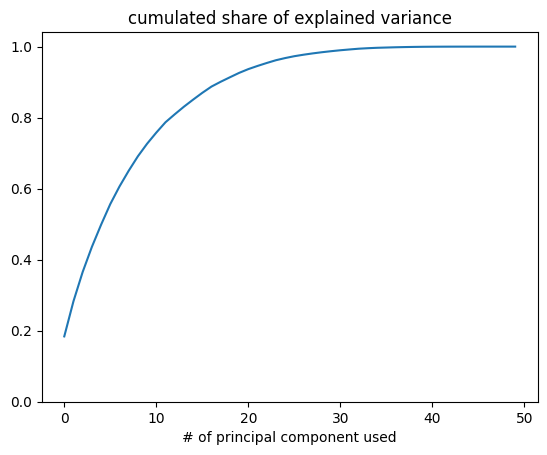

In [35]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylim(ymin=0)
plt.title('cumulated share of explained variance')
plt.xlabel('# of principal component used');